# Librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

# Análisis exploratorio

In [2]:
data = pd.read_csv('Data/ds_index_next.csv')
data.shape

(87438, 43)

In [3]:
data.head()

,YEAR,CODE,VQ_MARKET_CAP,CSR__ROE,VR__EV_TO_EBIT,CSR__ROC_JOEL_GREENBLATT,CSR__OPERATING_MARGIN,VQ__PIOTROSKI_F_SCORE,VR__PS_RATIO,VR__PB_RATIO,...,RISK,INDUSTRY01,INDUSTRY02,RETURNS_NEXT,RETURNS_CAT,RETURNS_NEXT_CAT,INDEX_RETURNS,INDEX_RETURNS_NEXT,RETURNS_vs_INDEX,RETURNS_vs_INDEX_NEXT
0,2014,ETE,31002.7009,72.22,28.98,8.00,5.10,7,0.56,46.73,...,3.472920,NaN,NaN,-0.512675,POSITIVE,NEGATIVE,0.123866,-0.006928,WINS,LOSES
1,2010,ETE,8712.4952,317.83,24.53,9.21,15.92,5,1.33,72.37,...,0.730981,NaN,NaN,0.045082,POSITIVE,POSITIVE,0.110019,-0.011220,WINS,WINS
2,2015,ETE,14384.6808,0.00,28.67,5.90,7.28,7,0.41,0.00,...,6.159618,NaN,NaN,0.897959,NEGATIVE,POSITIVE,-0.006928,0.112374,LOSES,WINS
3,2012,ETE,12732.3534,27.89,19.82,11.46,8.02,5,0.73,6.03,...,0.649843,NaN,NaN,0.657980,POSITIVE,POSITIVE,0.116776,0.263905,WINS,WINS
4,2007,ETE,8191.2308,2122.84,25.13,14.74,11.92,5,1.16,0.00,...,0.797453,NaN,NaN,-0.502987,POSITIVE,NEGATIVE,0.036538,-0.375847,WINS,LOSES


## Preprocesamiento de variables

In [4]:
gb = data[['YEAR', 'CODE', 'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT', 'RETURNS_NEXT']]
gb.head()

,YEAR,CODE,CSR__ROC_JOEL_GREENBLATT,VR__EV_TO_EBIT,RETURNS_NEXT
0,2014,ETE,8.00,28.98,-0.512675
1,2010,ETE,9.21,24.53,0.045082
2,2015,ETE,5.90,28.67,0.897959
3,2012,ETE,11.46,19.82,0.657980
4,2007,ETE,14.74,25.13,-0.502987


In [5]:
gb.query('YEAR > 1990 & YEAR < 2016', inplace=True)
gb.dropna(inplace=True)
gb['RETURNS_NEXT_RANKING'] = gb.groupby(by=['YEAR'])['RETURNS_NEXT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
gb.head()

,YEAR,CODE,CSR__ROC_JOEL_GREENBLATT,VR__EV_TO_EBIT,RETURNS_NEXT,RETURNS_NEXT_RANKING
0,2014,ETE,8.00,28.98,-0.512675,3934.0
1,2010,ETE,9.21,24.53,0.045082,901.0
2,2015,ETE,5.90,28.67,0.897959,389.0
3,2012,ETE,11.46,19.82,0.657980,651.0
4,2007,ETE,14.74,25.13,-0.502987,1065.0


# Aproximación 1

In [6]:
gb1 = gb[['YEAR','CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT', 'RETURNS_NEXT_RANKING']]

## División y escalado de datos

In [7]:
for y in gb1['YEAR'].unique():
    tmp = gb1.query('YEAR == @y')['CSR__ROC_JOEL_GREENBLATT']
    q1 = tmp.quantile(0.25)
    q3 = tmp.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    gb1.drop(gb1.loc[(gb1['YEAR'] == y) &
                     ((gb1['CSR__ROC_JOEL_GREENBLATT'] < fence_low) |
                      (gb1['CSR__ROC_JOEL_GREENBLATT'] > fence_high))].index, inplace=True)
    
    tmp = gb1.query('YEAR == @y')['VR__EV_TO_EBIT']
    q1 = tmp.quantile(0.25)
    q3 = tmp.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    gb1.drop(gb1.loc[(gb1['YEAR'] == y) &
                     ((gb1['VR__EV_TO_EBIT'] < fence_low) |
                      (gb1['VR__EV_TO_EBIT'] > fence_high))].index, inplace=True)

In [8]:
gb1['CSR__ROC_JOEL_GREENBLATT_RANKING'] = gb.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
gb1['VR__EV_TO_EBIT_RANKING'] = gb.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))

gb1.drop(['YEAR','CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT'], axis=1, inplace=True)
gb1.head()

,RETURNS_NEXT_RANKING,CSR__ROC_JOEL_GREENBLATT_RANKING,VR__EV_TO_EBIT_RANKING
0,3934.0,2315.0,3100.0
1,901.0,1697.0,2264.0
2,389.0,2338.0,3017.0
3,651.0,1712.0,2279.0
4,1065.0,1001.0,1544.0


In [9]:
X1 = gb1.drop(['RETURNS_NEXT_RANKING'], axis=1)
y1 = gb1['RETURNS_NEXT_RANKING']

feature_names = X1.columns

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, shuffle= True, random_state=10, test_size=0.25)

## Algoritmos

### XGBoost k-fold

In [10]:
param_dist = {'objective': 'reg:linear',
              'max_depth': 5,
              'colsample_bytree': 0.7,
              'alpha': 10,
              'learning_rate': 0.15,
              'silent': 1}

n_folds = 3
early_stopping = 10

xg_train = xgb.DMatrix(X1_train, label=y1_train)

cv = xgb.cv(param_dist, xg_train, 500, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-rmse:1594.73+1.72435	test-rmse:1595.27+3.87867
[1]	train-rmse:1445.75+1.40416	test-rmse:1446.6+5.07581
[2]	train-rmse:1327.59+2.88854	test-rmse:1329.09+6.21466
[3]	train-rmse:1235.09+4.36962	test-rmse:1237.34+7.39172
[4]	train-rmse:1157.44+7.88803	test-rmse:1160.24+8.91157
[5]	train-rmse:1097.79+11.7298	test-rmse:1101.18+12.0399
[6]	train-rmse:1046.97+7.15888	test-rmse:1051.31+8.08607
[7]	train-rmse:1011.86+9.46726	test-rmse:1017.02+10.042
[8]	train-rmse:985.634+11.375	test-rmse:991.306+11.8587
[9]	train-rmse:965.671+13.1239	test-rmse:971.996+13.3746
[10]	train-rmse:950.542+14.6341	test-rmse:957.525+14.748
[11]	train-rmse:934.162+9.33276	test-rmse:942.37+10.404
[12]	train-rmse:925.556+10.235	test-rmse:934.265+11.34
[13]	train-rmse:919.179+10.8424	test-rmse:928.323+12.1108
[14]	train-rmse:910.89+6.28202	test-rmse:920.902+8.33325
[15]	train-rmse:906.899+6.90993	test-rmse:917.44+9.02188
[16]	train-rmse:904.081+7.29312	test-rmse:915.097+9.30519
[17]	train-rmse:900.818+8.25082	tes

In [11]:
xg_reg_fold = xgb.train(params=param_dist, dtrain=xg_train, num_boost_round=cv.shape[0])

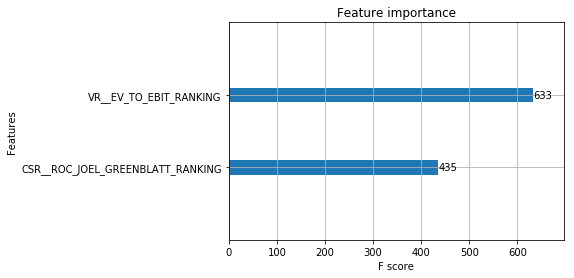

In [12]:
xgb.plot_importance(xg_reg_fold)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

**Save DATA**

In [13]:
save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
             'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
             'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))

In [14]:
result = save[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
result.dropna(inplace=True)
result_xg = xgb.DMatrix(result)
result['prediction'] = xg_reg_fold.predict(result_xg)

In [15]:
save = pd.concat([save, result['prediction']], axis=1, join='inner')
save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
    .transform(lambda x: x.rank(method='dense', ascending=True))
save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
           'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
save.to_csv('Results/metrics_XGB_KF_GB_OUTLIERS.csv', index=False)

# Aproximación 2

In [16]:
gb2 = gb[['YEAR','CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT', 'RETURNS_NEXT_RANKING']]

In [17]:
for y in gb2['YEAR'].unique():
    tmp = gb2.query('YEAR == @y')['CSR__ROC_JOEL_GREENBLATT']
    q1 = tmp.quantile(0.25)
    q3 = tmp.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    gb2.drop(gb2.loc[(gb2['YEAR'] == y) &
                     ((gb2['CSR__ROC_JOEL_GREENBLATT'] < fence_low) |
                      (gb2['CSR__ROC_JOEL_GREENBLATT'] > fence_high))].index, inplace=True)
    
    tmp = gb2.query('YEAR == @y')['VR__EV_TO_EBIT']
    q1 = tmp.quantile(0.25)
    q3 = tmp.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    gb2.drop(gb2.loc[(gb2['YEAR'] == y) &
                     ((gb2['VR__EV_TO_EBIT'] < fence_low) |
                      (gb2['VR__EV_TO_EBIT'] > fence_high))].index, inplace=True)

In [18]:
gb2['CSR__ROC_JOEL_GREENBLATT_RANKING'] = gb2.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
gb2['VR__EV_TO_EBIT_RANKING'] = gb2.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))

gb2.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT'], axis=1, inplace=True)
gb2.head()

,YEAR,RETURNS_NEXT_RANKING,CSR__ROC_JOEL_GREENBLATT_RANKING,VR__EV_TO_EBIT_RANKING
0,2014,3934.0,1720.0,2099.0
1,2010,901.0,1288.0,1483.0
2,2015,389.0,1746.0,2153.0
3,2012,651.0,1299.0,1578.0
4,2007,1065.0,801.0,993.0


In [19]:
final = pd.DataFrame()
for x in range(2000, 2018):
    gbT = gb2.query('YEAR >= @x-10 & YEAR <= @x-1')[['CSR__ROC_JOEL_GREENBLATT_RANKING',
                                                     'VR__EV_TO_EBIT_RANKING',
                                                     'RETURNS_NEXT_RANKING']]
    X2 = gbT.drop(['RETURNS_NEXT_RANKING'], axis=1)
    y2 = gbT['RETURNS_NEXT_RANKING']

    feature_names = X2.columns

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, shuffle= True, random_state=10, test_size=0.25)
    
    param_dist = {'objective': 'reg:linear',  
                  'max_depth': 5,
                  'colsample_bytree': 0.7,
                  'alpha': 10,
                  'learning_rate': 0.15,
                  'silent': 1}

    n_folds = 3
    early_stopping = 10

    xg_train = xgb.DMatrix(X2_train, label=y2_train)

    cv = xgb.cv(param_dist, xg_train, 500, nfold=n_folds, early_stopping_rounds=early_stopping)
    
    xg_reg_fold = xgb.train(params=param_dist, dtrain=xg_train, num_boost_round=cv.shape[0])
    
    save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
                 'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
                 'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
    save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
            .transform(lambda x: x.rank(method='dense', ascending=False))
    save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
            .transform(lambda x: x.rank(method='dense', ascending=True))
    
    result = save.query('YEAR == @x')[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
    result.dropna(inplace=True)
    result_xg = xgb.DMatrix(result)
    result['prediction'] = xg_reg_fold.predict(result_xg)
    
    save = pd.concat([save, result['prediction']], axis=1, join='inner')
    save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))
    save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
               'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
    save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                    'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
    save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
    
    final = final.append(save)

final.to_csv('Results/metrics_XGB_KF_W10_GB_OUTLIERS.csv', index=False)

# Aproximación 3

In [20]:
gb3 = gb[['YEAR','CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT', 'RETURNS_NEXT_RANKING']]

In [21]:
for y in gb3['YEAR'].unique():
    tmp = gb3.query('YEAR == @y')['CSR__ROC_JOEL_GREENBLATT']
    q1 = tmp.quantile(0.25)
    q3 = tmp.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    gb3.drop(gb3.loc[(gb3['YEAR'] == y) &
                     ((gb3['CSR__ROC_JOEL_GREENBLATT'] < fence_low) |
                      (gb3['CSR__ROC_JOEL_GREENBLATT'] > fence_high))].index, inplace=True)
    
    tmp = gb3.query('YEAR == @y')['VR__EV_TO_EBIT']
    q1 = tmp.quantile(0.25)
    q3 = tmp.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    gb3.drop(gb3.loc[(gb2['YEAR'] == y) &
                     ((gb3['VR__EV_TO_EBIT'] < fence_low) |
                      (gb3['VR__EV_TO_EBIT'] > fence_high))].index, inplace=True)

In [22]:
gb3['CSR__ROC_JOEL_GREENBLATT_RANKING'] = gb3.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
        .transform(lambda x: x.rank(method='dense', ascending=False))
gb3['VR__EV_TO_EBIT_RANKING'] = gb3.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))

gb3.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT'], axis=1, inplace=True)
gb3.head()

,YEAR,RETURNS_NEXT_RANKING,CSR__ROC_JOEL_GREENBLATT_RANKING,VR__EV_TO_EBIT_RANKING
0,2014,3934.0,1779.0,2400.0
1,2010,901.0,1333.0,1715.0
2,2015,389.0,1811.0,2394.0
3,2012,651.0,1337.0,1810.0
4,2007,1065.0,836.0,1134.0


In [23]:
final = pd.DataFrame()
for x in range(2000, 2018):
    gbT = gb3.query('YEAR >= @x-5 & YEAR <= @x-1')[['CSR__ROC_JOEL_GREENBLATT_RANKING',
                                                    'VR__EV_TO_EBIT_RANKING',
                                                    'RETURNS_NEXT_RANKING']]
    X3 = gbT.drop(['RETURNS_NEXT_RANKING'], axis=1)
    y3 = gbT['RETURNS_NEXT_RANKING']

    feature_names = X3.columns

    scaler = StandardScaler().fit(X3)
    X3s = scaler.transform(X3)
    
    param_dist = {'objective': 'reg:linear',  
                  'max_depth': 5,
                  'colsample_bytree': 0.7,
                  'alpha': 10,
                  'learning_rate': 0.15,
                  'silent': 1}

    n_folds = 3
    early_stopping = 10

    xg_train = xgb.DMatrix(X3s, label=y3)

    cv = xgb.cv(param_dist, xg_train, 500, nfold=n_folds, early_stopping_rounds=early_stopping)
    
    xg_reg_fold = xgb.train(params=param_dist, dtrain=xg_train, num_boost_round=cv.shape[0])
    
    save = data[['YEAR', 'CODE', 'VQ_MARKET_CAP', 'IS_EPS_BASIC', 'IS__REVENUE', 'VR_PE_RATIO',
                 'VQ__PIOTROSKI_F_SCORE', 'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK',
                 'CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT']]
    save['CSR__ROC_JOEL_GREENBLATT_RANKING'] = save.groupby(by=['YEAR'])['CSR__ROC_JOEL_GREENBLATT'] \
            .transform(lambda x: x.rank(method='dense', ascending=False))
    save['VR__EV_TO_EBIT_RANKING'] = save.groupby(by=['YEAR'])['VR__EV_TO_EBIT'] \
            .transform(lambda x: x.rank(method='dense', ascending=True))
    
    result = save.query('YEAR == @x')[['CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING']]
    result.dropna(inplace=True)
    
    scaler = StandardScaler().fit(result)
    result_s = scaler.transform(result)
    result_xg = xgb.DMatrix(result_s)
    result['prediction'] = xg_reg_fold.predict(result_xg)
    
    save = pd.concat([save, result['prediction']], axis=1, join='inner')
    save['prediction'] = save.groupby(by=['YEAR'])['prediction'] \
        .transform(lambda x: x.rank(method='dense', ascending=True))
    save.drop(['CSR__ROC_JOEL_GREENBLATT', 'VR__EV_TO_EBIT',
               'CSR__ROC_JOEL_GREENBLATT_RANKING', 'VR__EV_TO_EBIT_RANKING'], axis=1, inplace=True)
    save.columns = ['YEAR', 'CODE', 'CAP', 'EPS', 'REVENUE', 'PER', 'PIOTROSKI',
                    'PRICE_START', 'PRICE_END', 'RETURNS', 'RISK', 'RANKING']
    save.sort_values(['YEAR', 'RANKING'], ascending=[True, True], inplace=True)
    
    final = final.append(save)

final.to_csv('Results/metrics_XGB_KF_W5_GB_OUTLIERS.csv', index=False)